# Fed vs. fasted: comparing RSNs in giant Mappers

Let's recreate Figure 4 in Poldrack et al. 2015, Nature Communications, using Mapper!

#### Load data

In [26]:
%pylab nbagg

from utils import *

Populating the interactive namespace from numpy and matplotlib


/Users/rafi/miniconda/envs/dyno/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['colors', 'product', 'barh']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
sessions = load_scrubbed(n_sessions=-1, merge=True,
                         apply_tmask=True,apply_rmask=True,
                         rmask_kwds=dict(n=12,minor=False),zscore=False)

splits = get_data_splits(sessions,zscore=True,groupby='day_of_week',groups={2: 'fast', 4: 'fed'})

bestres = 20
bestgain = 8.
overlap = (bestgain - 1) / bestgain

X_fed = splits.fed.X
X_fast = splits.fast.X

majorRSNs = ['Cingulo_opercular','Frontoparietal_1','Somatomotor','Visual_2','DMN',
             'Dorsal_Attention', 'Ventral_Attention', 'Salience', 'Visual_1', 'Medial_Parietal',
             'Parieto_occipital', 'Frontoparietal 2']

majorRSNs = np.sort(majorRSNs)

roi2rsn = np.array(sessions.atlas['data']['network'])
roi2rsn_clean = roi2rsn[np.isin(roi2rsn,majorRSNs)]

df_roi_rsn = pd.DataFrame(0,index=np.arange(roi2rsn_clean.shape[0]),columns=majorRSNs)
for ind,roi in enumerate(roi2rsn_clean):
    df_roi_rsn.loc[ind,roi] = 1

/Users/rafi/Documents/Stanford/Saggar_Lab/dyneusr/dyneusr/__init__.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'nbAgg' by the following code:
  File "/Users/rafi/miniconda/envs/dyno/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/rafi/miniconda/envs/dyno/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/rafi/miniconda/envs/dyno/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/rafi/miniconda/envs/dyno/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/rafi/miniconda/envs/dyno/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in

INFO:root:  [+] session: 14, file: sub028.txt
INFO:root:      keeping: 506 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 15, file: sub029.txt
INFO:root:      keeping: 500 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 16, file: sub030.txt
INFO:root:      keeping: 513 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 17, file: sub032.txt
INFO:root:      keeping: 506 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 18, file: sub035.txt
INFO:root:      keeping: 497 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 19, file: sub036.txt
INFO:root:      keeping: 450 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 20, file: sub037.txt
INFO:root:      keeping: 503 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 21, file: sub038.txt
INFO:root:      keeping: 515 (time points)
INFO:root:     

INFO:root:      keeping: 488 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 79, file: sub100.txt
INFO:root:      keeping: 506 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 80, file: sub101.txt
INFO:root:      keeping: 513 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 81, file: sub102.txt
INFO:root:      keeping: 503 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 82, file: sub103.txt
INFO:root:      keeping: 494 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 83, file: sub104.txt
INFO:root:      keeping: 517 (time points)
INFO:root:      keeping: 554 (regions)


            0.0 => day_of_week_0    x.shape: (510, 554)  RSN.shape: (510, 12)
            1.0 => day_of_week_1    x.shape: (5893, 554)  RSN.shape: (5893, 12)
            2.0 => fast             x.shape: (20262, 554)  RSN.shape: (20262, 12)
            4.0 => fed              x.shape: (15576, 554)  RSN.shape: (15576, 12)


#### Class definition for null model, SBM

In [194]:
import operator
from matplotlib import patches
import collections

class nullSBM(object):
    def __init__(self):
        pass
    
    def __rsn_index_change(self,sorted_rsns):
        """
        Process sorted array of network labels, return an array of indexes where the label changes
        """
        index_array = []
        current_label = 'batman'
        for ind,label in enumerate(sorted_rsns):
            if label != current_label:
                current_label = label
                index_array.append(ind)
        # Add ending index
        index_array.append(len(sorted_rsns))
        return index_array
    
    def __get_mod(self,G):
        """
        Partition graph G into communities
        """
        partition = dict()
        # Get groups - node attribute that has a 1 for the RSN the node should belong to
        groups = nx.get_node_attributes(G,'group')
        # Iteration through each node (dictionary)
        for n in groups.keys():
            # Loop through each RSN and pull out the only one that has a 1 - that's our label
            # Implemented a try catch for rare cases where a node has a tie between groups
            try:
                nwlabel = [nw for nw in groups[n] if groups[n][nw] == 1][0]
            # Basically go through proportions which has the number of members in each RSN, find the max, and choose network that is alphabetically first
            except IndexError:
                props = nx.get_node_attributes(G,'proportions')
                values = [dic['value'] for dic in props[n]['multiclass']]
                highestnws = np.argwhere(values == np.max(values))
                highestnws = [sublist[0] for sublist in highestnws]
                nwlabel = props[n]['multiclass'][highestnws[0]]['label']
            partition[n] = nwlabel
        return partition
    
    def __sort_adjacency(self,G):
        """
        Take the adjacency matrix from the Mapper graph and sort it by RSN
        """
        partition = self.__get_mod(G)
        sorted_p = sorted(partition.items(), key=operator.itemgetter(1))
        # Creat new adjacency matrix from the partition
        nodes,comms = list(zip(*sorted_p))
        A = np.zeros((len(nodes),len(nodes)))
        for node in nodes:
            # Find neighbors of node
            for nbr in G[node]:
                # Create an edge
                A[nodes.index(node),nodes.index(nbr)] = 1
        # Return
        return A,comms  

    def __calc_SBM_param(self,G):
        """
        Take an ROI x ROI matrix from a DyNeuSR and estimates probabilities of connections between communities
        """
        A,labels = self.__sort_adjacency(G)
        # Get number of nodes in each community
        nodecount = collections.Counter(labels)
        sizes = [nodecount[key] for key in sorted(nodecount.keys())]
        # Get the indices of the bounds between RSN regions in the matrix
        bounds = self.__rsn_index_change(labels)
        # Create array to hold probabilities
        probs = np.zeros((len(set(labels)),len(set(labels))))
        # Go through bounds twice, once for each dimension
        for comm1,b1 in enumerate(bounds[:-1]):
            for comm2,b2 in enumerate(bounds[:-1]):
                # End index of the region in matrix that belongs to this RSN
                nextb1 = bounds[comm1+1]
                nextb2 = bounds[comm2+1]
                # Sum the values in this region
                num_edges = np.sum(A[b1:nextb1,b2:nextb2])
                # Divide by 2 if same community
                if comm1 == comm2:
                    num_edges /= 2
                # Divide by number of nodes in community 1 * nodes in community 2
                p = num_edges / float(sizes[comm1] * sizes[comm2])
                # Add to appropriate locations in probs
                probs[comm1,comm2] = p

        self.labels = labels
        
        return sizes, probs
    
    def __add_rsn_patches(self, ax, lenx, leny, boundaries, color_array, alpha_param = 1.0, offset = 1.0):
        """
        Plots rectangular patches vertically and horizontally for each network bounded by the indices
        provided using the colors provided
        """
        # Loop through boundaries
        for num,ind in enumerate(boundaries[:-1]):
            nextind = boundaries[num+1]
            hrect = patches.Rectangle((ind,ind), nextind-ind, nextind-ind,linewidth=1.5,edgecolor=color_array[num],facecolor='none',alpha=alpha_param)
            ax.add_patch(hrect)
            vrect = patches.Rectangle((ind,ind), nextind-ind, nextind-ind,linewidth=1.5,edgecolor=color_array[num],facecolor='none',alpha=alpha_param)
            ax.add_patch(vrect)
        
    def configure(self,sessions):
        """
        Calculate probabilities for each scan, use average probability to create one SBM model
        """
        P = []
        for sess_num,session in enumerate(sessions):
            print('Processing session %d out of %d...' % ((sess_num+1), len(sessions)))
            # Run Mapper
            results = run_mapper(session.X.T,df_roi_rsn,verbose=0,cover=km.Cover(bestres,overlap))
            # Get probs
            self.sizes,p = self.__calc_SBM_param(results['dG'].G_)
            if p.shape[0] != len(majorRSNs):
                print('Threw out session %d' % sess_num)
                continue
            # Append so we can get the mean
            P.append(p)

        self.probs = np.mean(P,axis=0)
        
    def run(self,num_itera=30):
        if num_itera == 1:
            self.G_ = nx.stochastic_block_model(self.sizes,self.probs)
            self.A = nx.to_numpy_array(G)
        else:
            # Run SBM
            Anull = [nx.to_numpy_array(nx.stochastic_block_model(self.sizes,self.probs)) for i in range(num_itera)]
            Anull_mean = np.mean(Anull,axis=0)

            self.A = Anull_mean
            self.G_ = nx.stochastic_block_model(self.sizes,self.probs)
        
        # Get partition/communities - loop through every node and find its RSN community based on the index bounds for each RSN
        bounds = np.array(self.__rsn_index_change(self.labels)[1:])
        bounds[-1] += 1
        self.partition = {node: np.where(node < bounds)[0][0] for node in list(self.G_.nodes())}
            

    def plot(self, add_cbar=True):
    
        rect_inds = self.__rsn_index_change(self.labels)

        plt.close('all')
        plt.rc('font', family='serif')
        plt.imshow(self.A,cmap='binary_r')
        plt.axis('off')
        plt.title('ROI x ROI matrix, SBM')
        ax = plt.gca()
        fig = plt.gcf()
        cmap = mpl.cm.get_cmap('tab20', 20)
        colors = cmap(np.linspace(0,1,20))

        self.__add_rsn_patches(ax,self.A.shape[1],self.A.shape[0],rect_inds,colors[:len(majorRSNs)],alpha_param=1.0,offset=2)

        # Create colorbar to label the RSN rectangles
        if add_cbar:
            # Use rect_inds to define which ticks are what colors
            # If our colormap is size of the matrix (554), then all indices within a RSN should be same color
            bar_colors = np.zeros((self.A.shape[0],4))
            # Holds the midpoint value of each RSN region to use for tick labels
            midticks = []
            for num,ind in enumerate(rect_inds[:-1]):
                nextind = rect_inds[num+1]
                bclr = np.matlib.repmat(colors[num],nextind-ind,1)
                bar_colors[ind:nextind,:] = bclr
                midticks.append((nextind+ind)/2.0)
            # Flip since matrix goes top to bottom
            bar_colors = bar_colors[::-1]
            midticks = self.A.shape[0] - np.array(midticks)

            cmap_bar = matplotlib.colors.ListedColormap(bar_colors)
            norm = mpl.colors.Normalize(vmin=0,vmax=self.A.shape[0])
            sm = plt.cm.ScalarMappable(cmap=cmap_bar, norm=norm)
            sm.set_array([])

            # Left colorbar
            cbaxes = fig.add_axes([0.18, 0.11, 0.02, 0.77]) 
            cbar = plt.colorbar(sm, ticks=midticks, cax = cbaxes)
            cbaxes.yaxis.set_ticks_position('left')
            rsns_pretty = np.sort(['Cingulo-opercular','Fronto-parietal 1','Somatomotor','Visual 2','DMN',
                 'Dorsal Attention', 'Ventral Attention', 'Salience', 'Visual 1', 'Medial Parietal',
                 'Parieto Occipital', 'Fronto-parietal 2'])
            cbar.ax.set_yticklabels(rsns_pretty)
            cbar.ax.tick_params(labelsize=7) 

        plt.show()
        
    def set_params(self,G):
        # Get probs
        self.sizes,self.probs = self.__calc_SBM_param(G)
        
    def draw(self):
        plt.close('all')
        # Generate colormap
        cmap = mpl.cm.get_cmap('tab20', 20)
        colors = cmap(np.linspace(0,1,20))

        pos = nx.spring_layout(self.G_,scale=0.5)
        for com in set(self.partition.values()) :
            list_nodes = [nodes for nodes in self.partition.keys() if self.partition[nodes] == com]
            nx.draw_networkx_nodes(self.G_, pos, list_nodes, node_size = 50, node_color = colors[com], edgecolors = 'none')

        nx.draw_networkx_edges(self.G_, pos, alpha=0.5)
        ax = plt.gca()
        ax.axis('off')
        fig = plt.gcf()
        fig.set_size_inches(8,8)
        

#### Run Mapper in anatomical space

Make one giant mapper for all of fed, all of fasted.

I think the more relevant results are the ones across all sessions much further down below, but I'll leave this here

In [30]:
# Run Mapper/DyNeuSR
results_fed = run_mapper(X_fed.T,df_roi_rsn,verbose=1,cover=km.Cover(bestres,overlap))
# Visualize DyNeuGraph
results_fed['dG'].visualize(path_html='results/fed_super_spatial_all.html', show=False, reset=True, static=False, PORT=8800)
# Run Mapper/DyNeuSR
results_fast = run_mapper(X_fast.T,df_roi_rsn,verbose=1,cover=km.Cover(bestres,overlap))
# Visualize DyNeuGraph
results_fast['dG'].visualize(path_html='results/fast_super_spatial_all.html', show=False, reset=True, static=False, PORT=8800)

KeplerMapper()
Mapping on data shaped (554, 15576) using lens shaped (554, 2)

Creating 400 hypercubes.

Created 385 edges and 183 nodes in 0:00:01.746042.


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fed_super_spatial_all.html
KeplerMapper()
Mapping on data shaped (554, 20262) using lens shaped (554, 2)

Creating 400 hypercubes.

Created 372 edges and 186 nodes in 0:00:02.039564.


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fast_super_spatial_all.html


DyNeuGraph()

In [31]:
dGfed = results_fed['dG']
dGfast = results_fast['dG']

#### Sweep resolution and gain - fed

These sweep cells were for testing purposes, no results to see...

In [ ]:
# Sweep resolution and gain
resolutions = [10,15,20,25,30,35,40]
gains = [2.,3.,4.,5.,6.,7.,8.]
dGfeds = dict() # Dict keyed by a tuple (R,G) and the values are DyNeuSR graphs
for res in resolutions:
    for gain in gains:
        overlap = (gain - 1) / gain
        # Run Mapper/DyNeuSR
        results_fed = run_mapper(X_fed.T,df_roi_rsn,verbose=1,cover=km.Cover(res,overlap))
        # Visualize DyNeuGraph
        results_fed['dG'].visualize(path_html='results/fed_super_spatial_R%d_G%d.html' % (res,int(gain)), show=False, reset=True, static=False, PORT=8800)
        dGfeds[(res,int(gain))] = results_fed['dG']

#### Sweep resolution and gain - fast

In [ ]:
# Sweep resolution and gain
resolutions = [10,15,20,25,30,35,40]
gains = [2.,3.,4.,5.,6.,7.,8.]
dGfasts = dict() # Dict keyed by a tuple (R,G) and the values are DyNeuSR graphs
for res in resolutions:
    for gain in gains:
        overlap = (gain - 1) / gain
        # Run Mapper/DyNeuSR
        results_fast = run_mapper(X_fast.T,df_roi_rsn,verbose=1,cover=km.Cover(res,overlap))
        # Visualize DyNeuGraph
        results_fast['dG'].visualize(path_html='results/fast_super_spatial_R%d_G%d.html' % (res,int(gain)), show=False, reset=True, static=False, PORT=8800)
        dGfasts[(res,int(gain))] = results_fast['dG']

#### Test different perplexity values

In [ ]:
perplexity = [2,5,10,20,30,40,50,75,100,200]
for perp in perplexity:
    # Run Mapper/DyNeuSR
    results_fed = run_mapper(X_fed.T,df_roi_rsn,verbose=1,cover=km.Cover(25,5./6.), projection=TSNE(perplexity=perp, init='random', random_state=0))
    # Visualize DyNeuGraph
    results_fed['dG'].visualize(path_html='results/fed_super_spatial_R25_G6_P%d.html' % (perp), show=False, reset=True, static=False, PORT=8800)

#### Calculate modularity

Only the functions below are relevant (there's like eight of them), none of the results are important. Keep going until the next note.

In [139]:
import operator
_,partition = get_mod(dGfed.G_,return_partition=True)
sorted_x = sorted(partition.items(), key=operator.itemgetter(1))
sorted_x

[('cube68_cluster0', 'Cingulo_opercular'),
 ('cube87_cluster0', 'Cingulo_opercular'),
 ('cube88_cluster0', 'Cingulo_opercular'),
 ('cube89_cluster0', 'Cingulo_opercular'),
 ('cube90_cluster0', 'Cingulo_opercular'),
 ('cube92_cluster0', 'Cingulo_opercular'),
 ('cube105_cluster0', 'Cingulo_opercular'),
 ('cube106_cluster0', 'Cingulo_opercular'),
 ('cube107_cluster0', 'Cingulo_opercular'),
 ('cube108_cluster0', 'Cingulo_opercular'),
 ('cube109_cluster0', 'Cingulo_opercular'),
 ('cube110_cluster0', 'Cingulo_opercular'),
 ('cube111_cluster0', 'Cingulo_opercular'),
 ('cube112_cluster0', 'Cingulo_opercular'),
 ('cube125_cluster0', 'Cingulo_opercular'),
 ('cube126_cluster0', 'Cingulo_opercular'),
 ('cube127_cluster0', 'Cingulo_opercular'),
 ('cube128_cluster0', 'Cingulo_opercular'),
 ('cube129_cluster0', 'Cingulo_opercular'),
 ('cube130_cluster0', 'Cingulo_opercular'),
 ('cube145_cluster0', 'Cingulo_opercular'),
 ('cube146_cluster0', 'Cingulo_opercular'),
 ('cube147_cluster0', 'Cingulo_opercul

In [4]:
import community
def get_mod(G, return_partition=False):
    partition = dict()
    # Get groups - node attribute that has a 1 for the RSN the node should belong to
    groups = nx.get_node_attributes(G,'group')
    # Iteration through each node (dictionary)
    for n in groups.keys():
        # Loop through each RSN and pull out the only one that has a 1 - that's our label
        # Implemented a try catch for rare cases where a node has a tie between groups
        try:
            nwlabel = [nw for nw in groups[n] if groups[n][nw] == 1][0]
        # Basically go through proportions which has the number of members in each RSN, find the max, and choose network that is alphabetically first
        except IndexError:
            props = nx.get_node_attributes(G,'proportions')
            values = [dic['value'] for dic in props[n]['multiclass']]
            highestnws = np.argwhere(values == np.max(values))
            highestnws = [sublist[0] for sublist in highestnws]
            nwlabel = props[n]['multiclass'][highestnws[0]]['label']
        partition[n] = nwlabel
    Q = community.modularity(partition,G)
    if return_partition:
        return Q,partition
    else:
        return Q

In [78]:
Qfeds = {key: get_mod(dGfeds[key].G_) for key in dGfeds}
Qfasts = {key: get_mod(dGfasts[key].G_) for key in dGfasts} # Same thing, key is a tuple (R,G) and value is Q

<IPython.core.display.Javascript object>


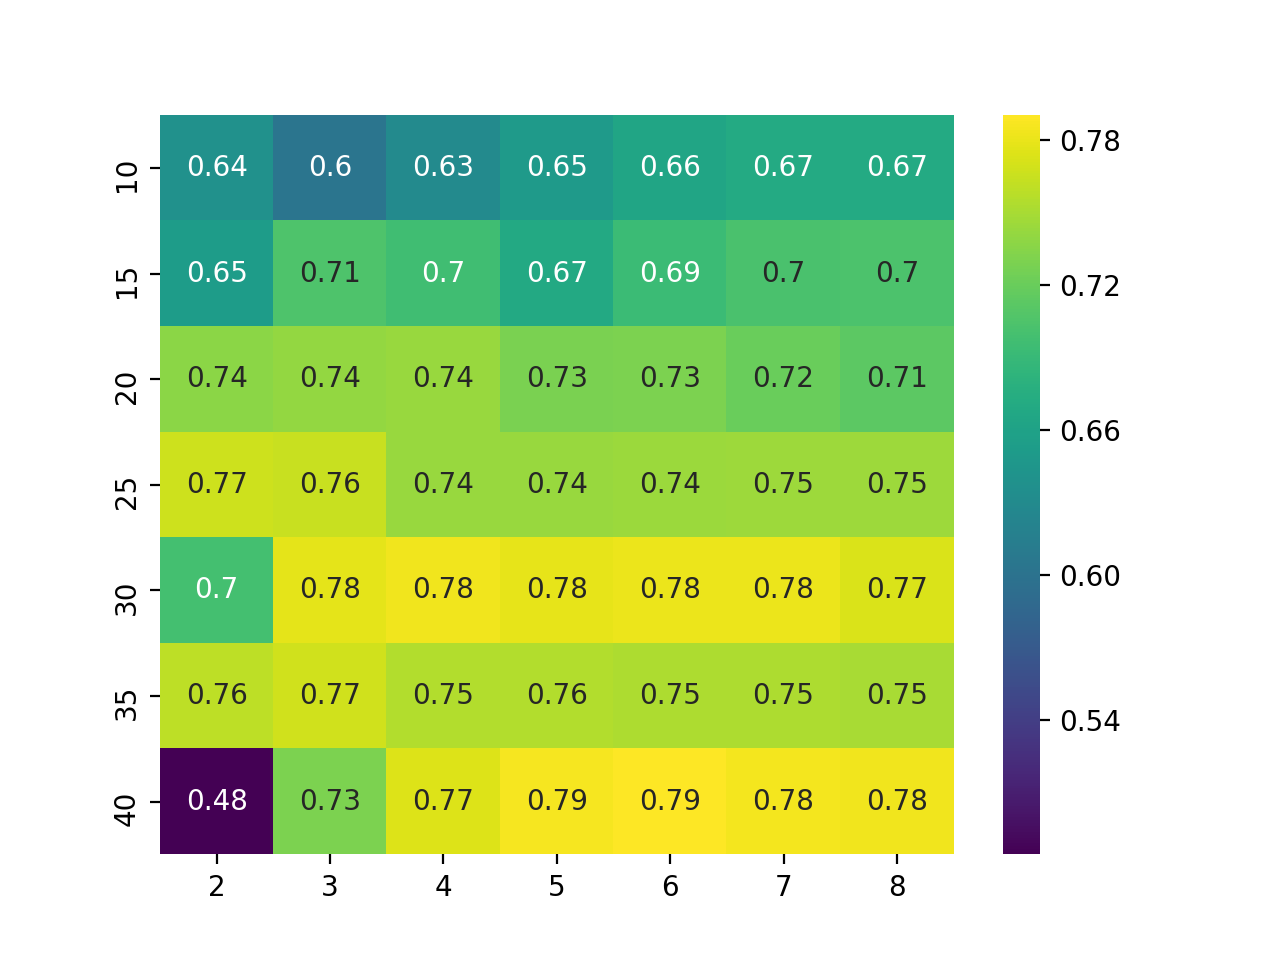

In [87]:
# Create heatmap that matches the table of graphs
import pandas as pd
import seaborn as sns

ser = pd.Series(list(Qfeds.values()),
                  index=pd.MultiIndex.from_tuples(Qfeds.keys()))
df = ser.unstack().fillna(0)
plt.close('all')
sns.heatmap(df, annot=True, cmap='viridis')

<IPython.core.display.Javascript object>


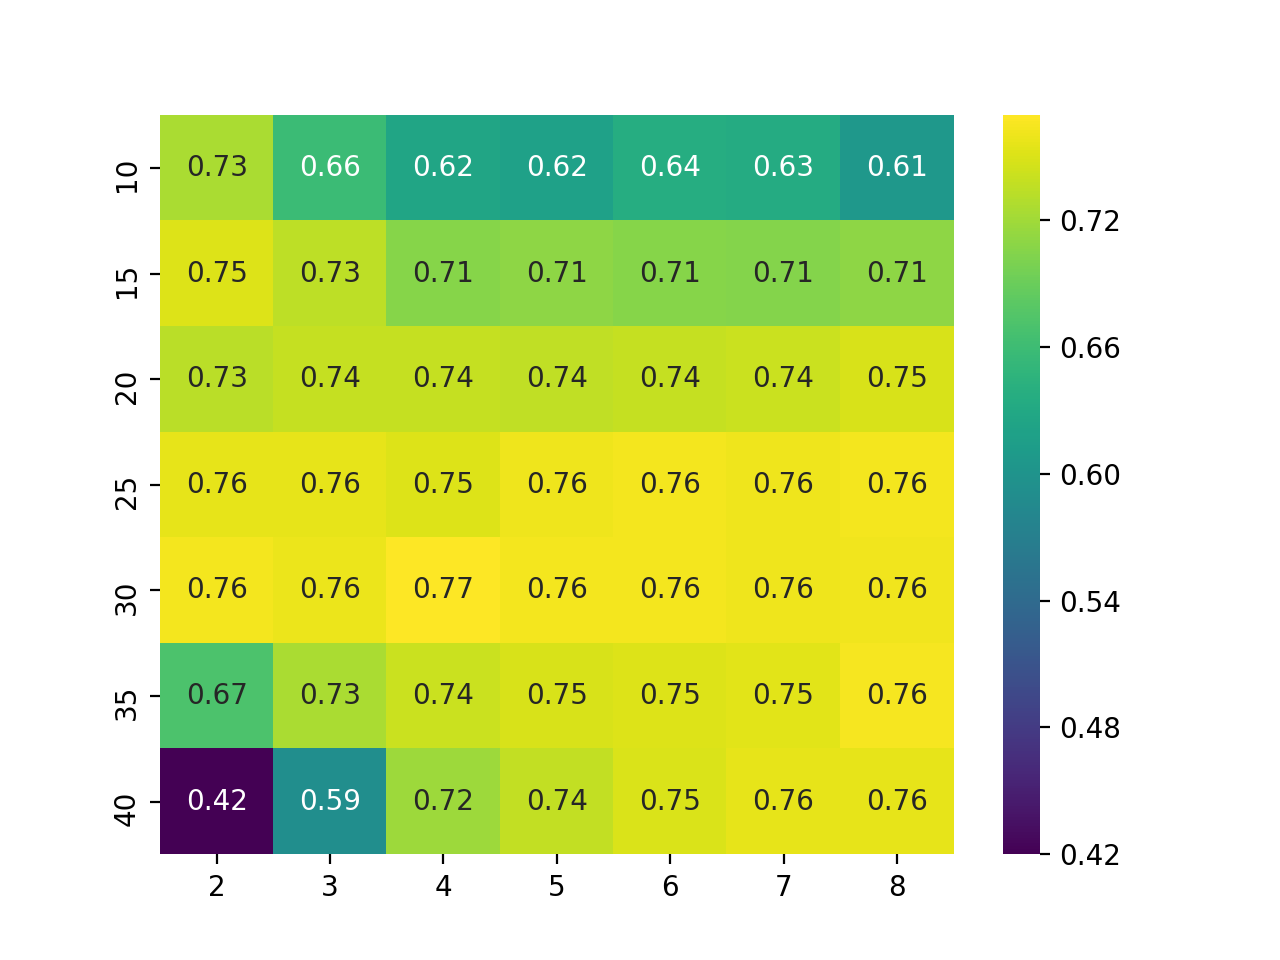

In [86]:
ser = pd.Series(list(Qfasts.values()),
                  index=pd.MultiIndex.from_tuples(Qfasts.keys()))
df = ser.unstack().fillna(0)
plt.close('all')
sns.heatmap(df, annot=True, cmap='viridis')

### Calculate network measures for each RSN, in each condition

#### Modularity

In [141]:
Qfed = get_mod(dGfed.G_)
Qfast = get_mod(dGfast.G_)
print('Fed graph: Q = %.3f' % Qfed)
print('Fast graph: Q = %.3f' % Qfast)

Fed graph: Q = 0.766
Fast graph: Q = 0.709


In [142]:
# What is the optimal community structure?
partition2 = community.best_partition(dGfed.G_)
size = len(set(partition2.values()))
Qfed = community.modularity(partition2,dGfed.G_)
print('Fed optimal: Q = %.3f' % Qfed)
print('Number of communities: %d' % size)

partition2 = community.best_partition(dGfast.G_)
size = len(set(partition2.values()))
Qfast = community.modularity(partition2,dGfast.G_)
print('Fast optimal: Q = %.3f' % Qfast)
print('Number of communities: %d' % size)

Fed optimal: Q = 0.846
Number of communities: 22
Fast optimal: Q = 0.846
Number of communities: 18


#### Within-module degree

In [141]:
import collections

def within_module_degree(G, partition, normalize = False):
    # If we want to normalize by community size
    if normalize:
        # Get size of each RSN community
        nodecount = collections.Counter(partition.values())
    inmod_deg = collections.defaultdict(list)
    # Loop through nodes, calculate degree within module, append to list by RSN
    for node in G.nodes():
        # Get neighbors of node and only count the ones that are in same RSN
        wmod = len([1 for nbr in G[node] if partition[nbr] == partition[node]])
        if normalize:
            # Normalize by community size
            wmod /= float(nodecount[partition[node]])
        inmod_deg[partition[node]].append(wmod)

    return inmod_deg # This is a dictionary keyed by RSN, values are lists of within module degree of every node in RSN

In [190]:
from matplotlib import cm

def plot_network_measure(network_measure1,network_measure2,y_axlabel,plot_title,y_lim,null_measure=None):
    """
    Take a dictionary keyed by RSN, values are lists of a network measure value for every node in RSN
    Plot bars comparing fed and fasted states for each RSN
    """

    # Bar plot for fed - this is a list of tuples (RSN,mean,std)
    bars_fed = [(np.mean(network_measure1[rsn]),np.std(network_measure1[rsn])) for rsn in sorted(network_measure1.keys())]
    barh_fed,barerr_fed = list(zip(*bars_fed))

    # Bar plot for fast - this is a list of tuples (RSN,mean,std)
    bars_fast = [(np.mean(network_measure2[rsn]),np.std(network_measure2[rsn])) for rsn in sorted(network_measure2.keys())]
    barh_fast,barerr_fast = list(zip(*bars_fast))

    cmap = cm.get_cmap('viridis', 20)
    colors = cmap(np.linspace(0,1,10))

    index = np.arange(len(bars_fed))
    
    if null_measure is None:
        bar_width = 0.35
        error_config = {'ecolor': '0.3'}

        plt.close('all')
        fig, ax = plt.subplots(figsize=(12,4))

        rects1 = ax.bar(index, barh_fed, bar_width,
                        color=colors[2],
                        yerr=barerr_fed, error_kw=error_config,
                        label='Fed')
        rects2 = ax.bar(index + bar_width, barh_fast, bar_width,
                        color=colors[7],
                        yerr=barerr_fast, error_kw=error_config,
                        label='Fasted')

        ax.set_ylabel(y_axlabel)
        ax.set_title(plot_title)
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(majorRSNs,fontsize=7)
        ax.set_ylim([0,y_lim])
        ax.legend()

        fig.tight_layout()
        plt.show()
    else:
        bars_null = [(np.mean(null_measure[rsn]),np.std(null_measure[rsn])) for rsn in sorted(null_measure.keys())]
        barh_null,barerr_null = list(zip(*bars_null))
        
        bar_width = 0.25
        error_config = {'ecolor': '0.3'}

        plt.close('all')
        fig, ax = plt.subplots(figsize=(12,4))

        rects1 = ax.bar(index - bar_width, barh_fed, bar_width,
                        color=colors[2],
                        yerr=barerr_fed, error_kw=error_config,
                        label='Fed')
        rects2 = ax.bar(index, barh_fast, bar_width,
                        color=colors[7],
                        yerr=barerr_fast, error_kw=error_config,
                        label='Fasted')
        rects3 = ax.bar(index + bar_width, barh_null, bar_width,
                        color='gray',
                        yerr=barerr_null, error_kw=error_config,
                        label='SBM')

        ax.set_ylabel(y_axlabel)
        ax.set_title(plot_title)
        ax.set_xticks(index)
        ax.set_xticklabels(majorRSNs,fontsize=7)
        ax.set_ylim([0,y_lim])
        ax.legend()

        fig.tight_layout()
        plt.show()


<IPython.core.display.Javascript object>


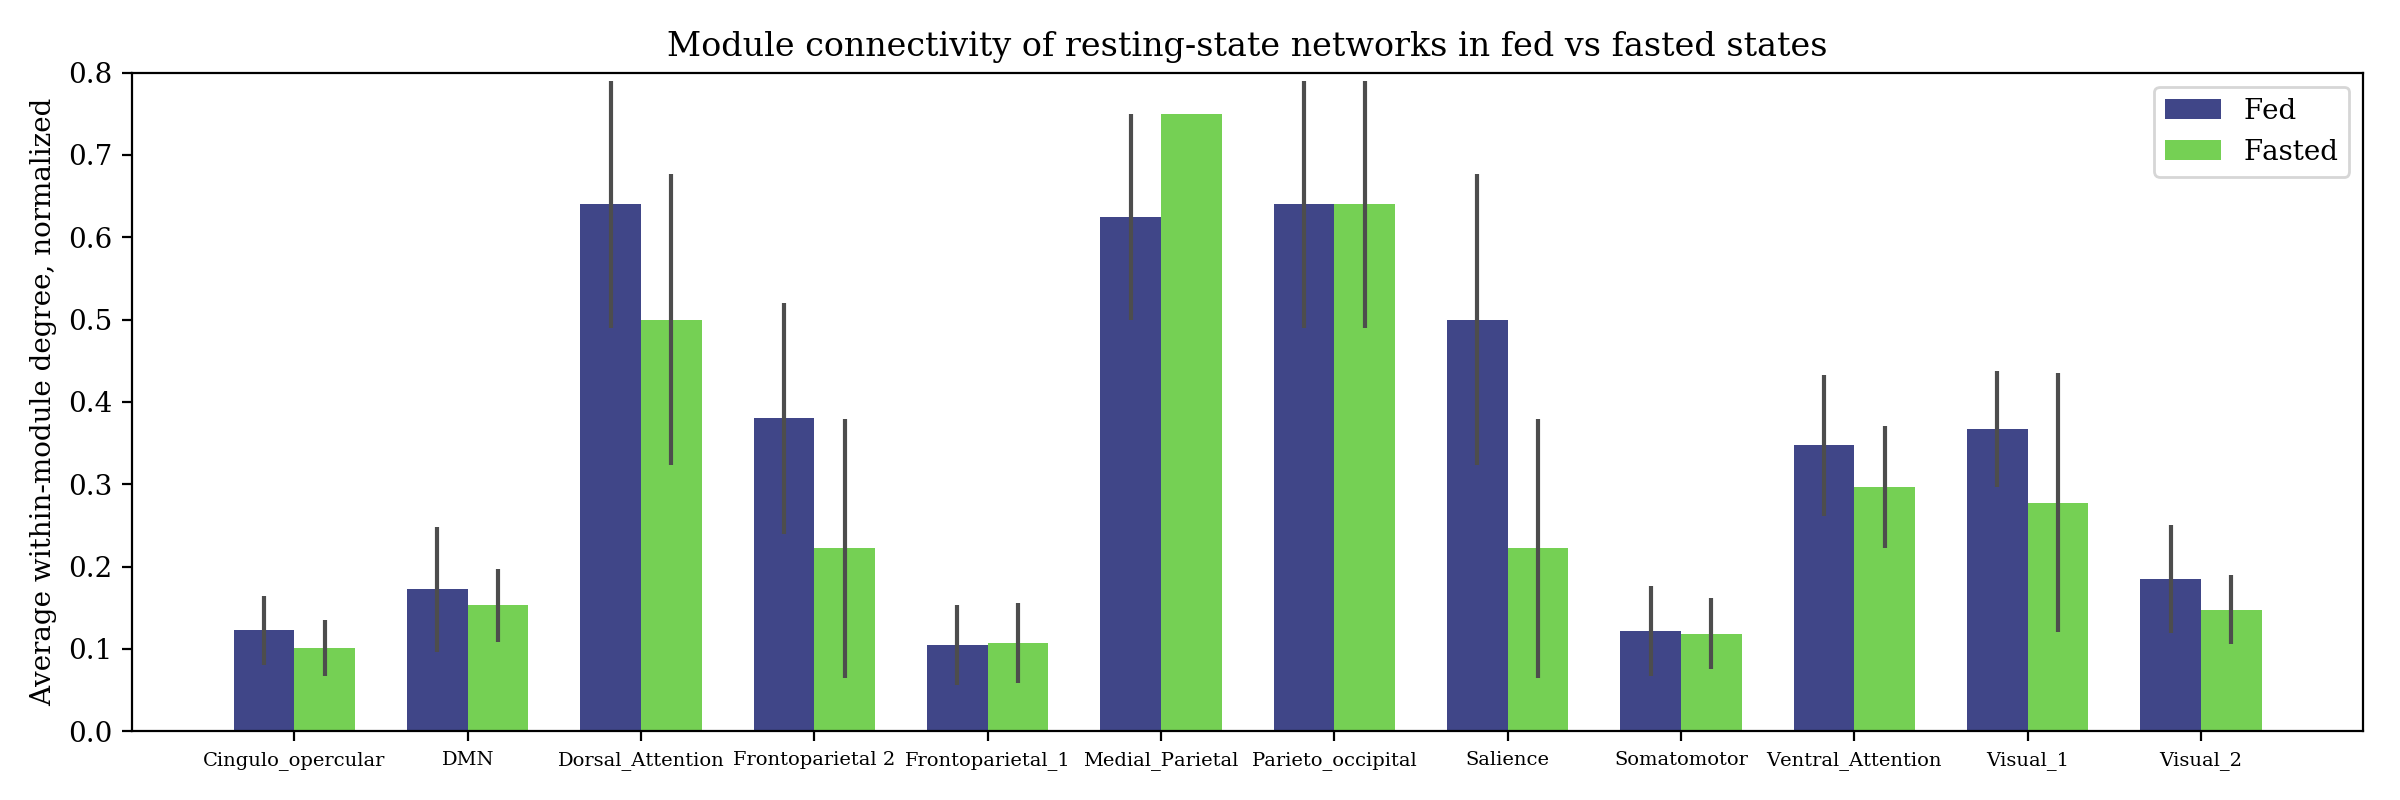

In [144]:
_,part_fed = get_mod(dGfed.G_,return_partition=True)
_,part_fast = get_mod(dGfast.G_,return_partition=True)

inmod_fed = within_module_degree(dGfed.G_, part_fed,normalize=True)
inmod_fast = within_module_degree(dGfast.G_, part_fast,normalize=True)

plot_network_measure(inmod_fed,inmod_fast,
                     'Average within-module degree, normalized',
                     'Module connectivity of resting-state networks in fed vs fasted states',
                     0.8
                    )

#### Betweenness centrality

In [149]:
import collections

def betweenness(G, partition):
    BC = nx.betweenness_centrality(G)
    btw = collections.defaultdict(list)
    # Loop through nodes with betweenness calculated, and append to appropriate RSN
    for node in BC:
        btw[partition[node]].append(BC[node])

    return btw # This is a dictionary keyed by RSN, values are lists of betweenness of every node in RSN

<IPython.core.display.Javascript object>


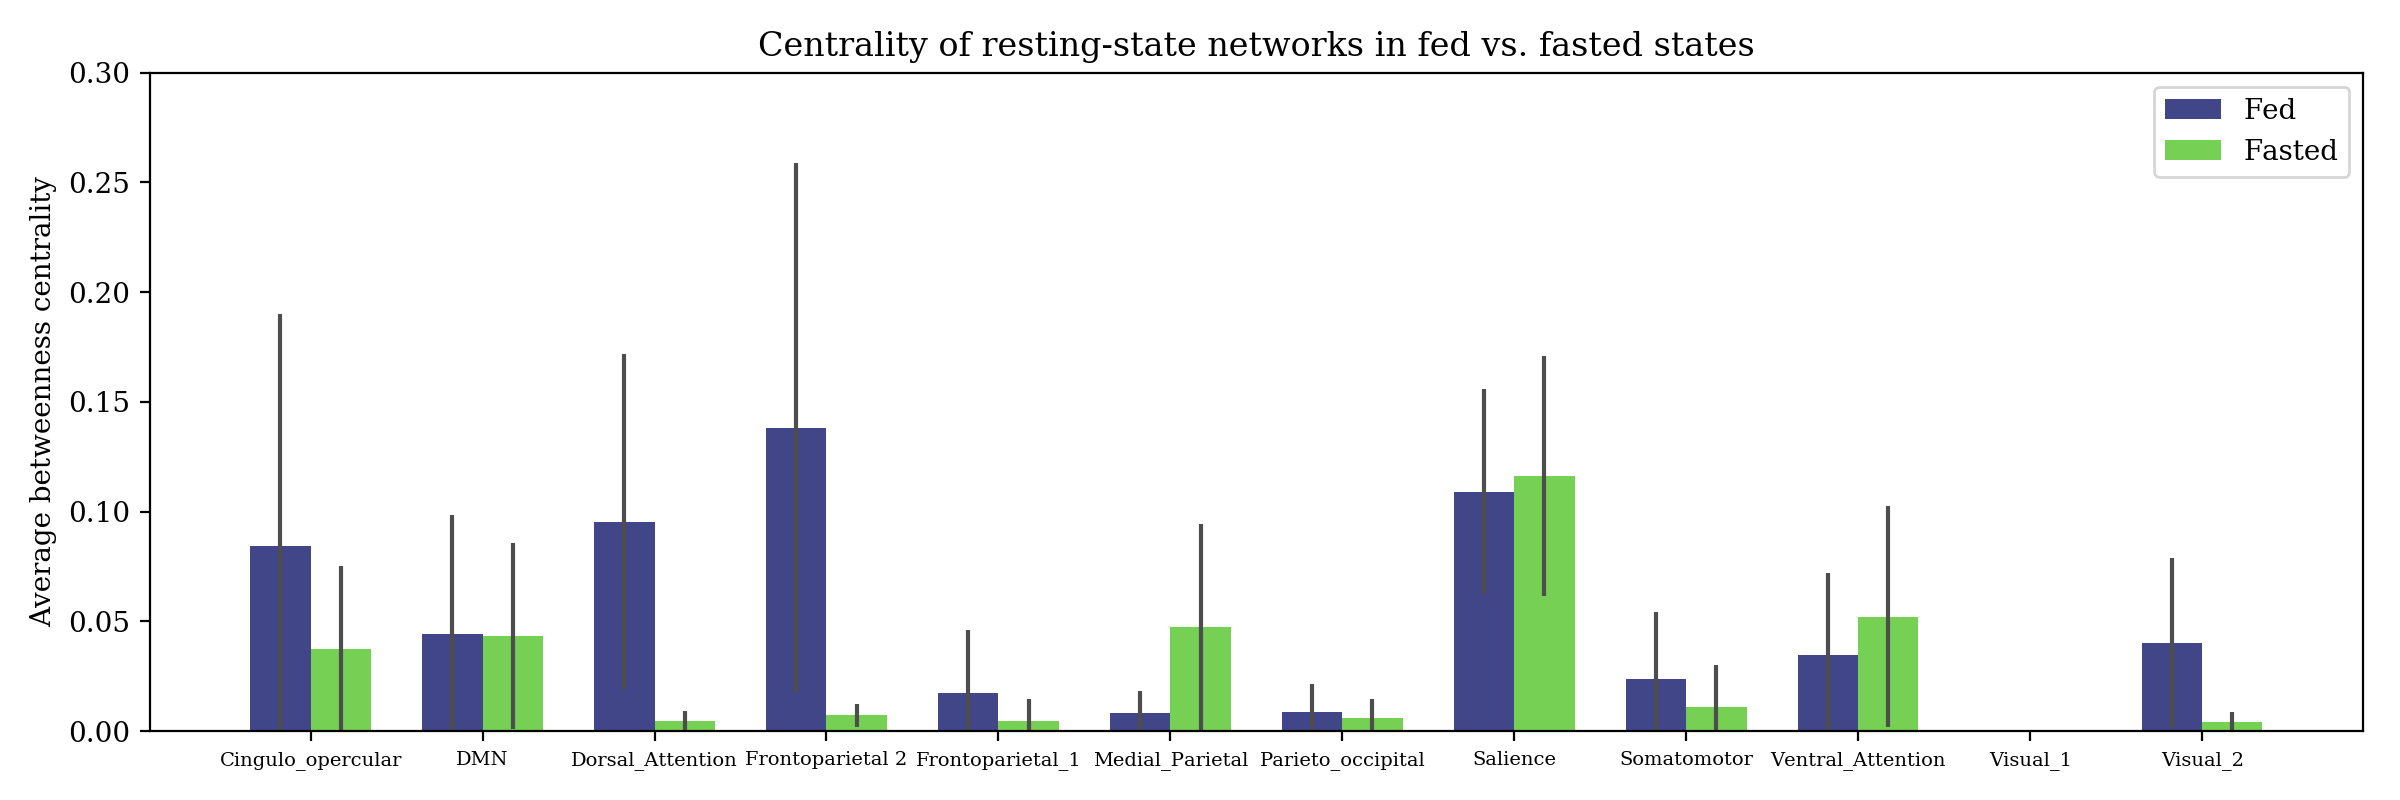

In [150]:
_,part_fed = get_mod(dGfed.G_,return_partition=True)
_,part_fast = get_mod(dGfast.G_,return_partition=True)

btw_fed = betweenness(dGfed.G_,part_fed)
btw_fast = betweenness(dGfast.G_,part_fast)

plot_network_measure(btw_fed,btw_fast,
                     'Average betweenness centrality',
                     'Centrality of resting-state networks in fed vs. fasted states',
                     0.3
                    )

#### Participation coefficient

In [153]:
from bct import participation_coef

def calc_particip(G,partition,A,C):
    # Calculate participation coefficient for each node
    P = participation_coef(A,C)
    # Create a dictionary keyed by RSN, values are lists of particip coef of every node in RSN
    particip = collections.defaultdict(list)
    for ind,p in enumerate(P):
        particip[partition[list(G.nodes())[ind]]].append(p)
        
    return particip

<IPython.core.display.Javascript object>


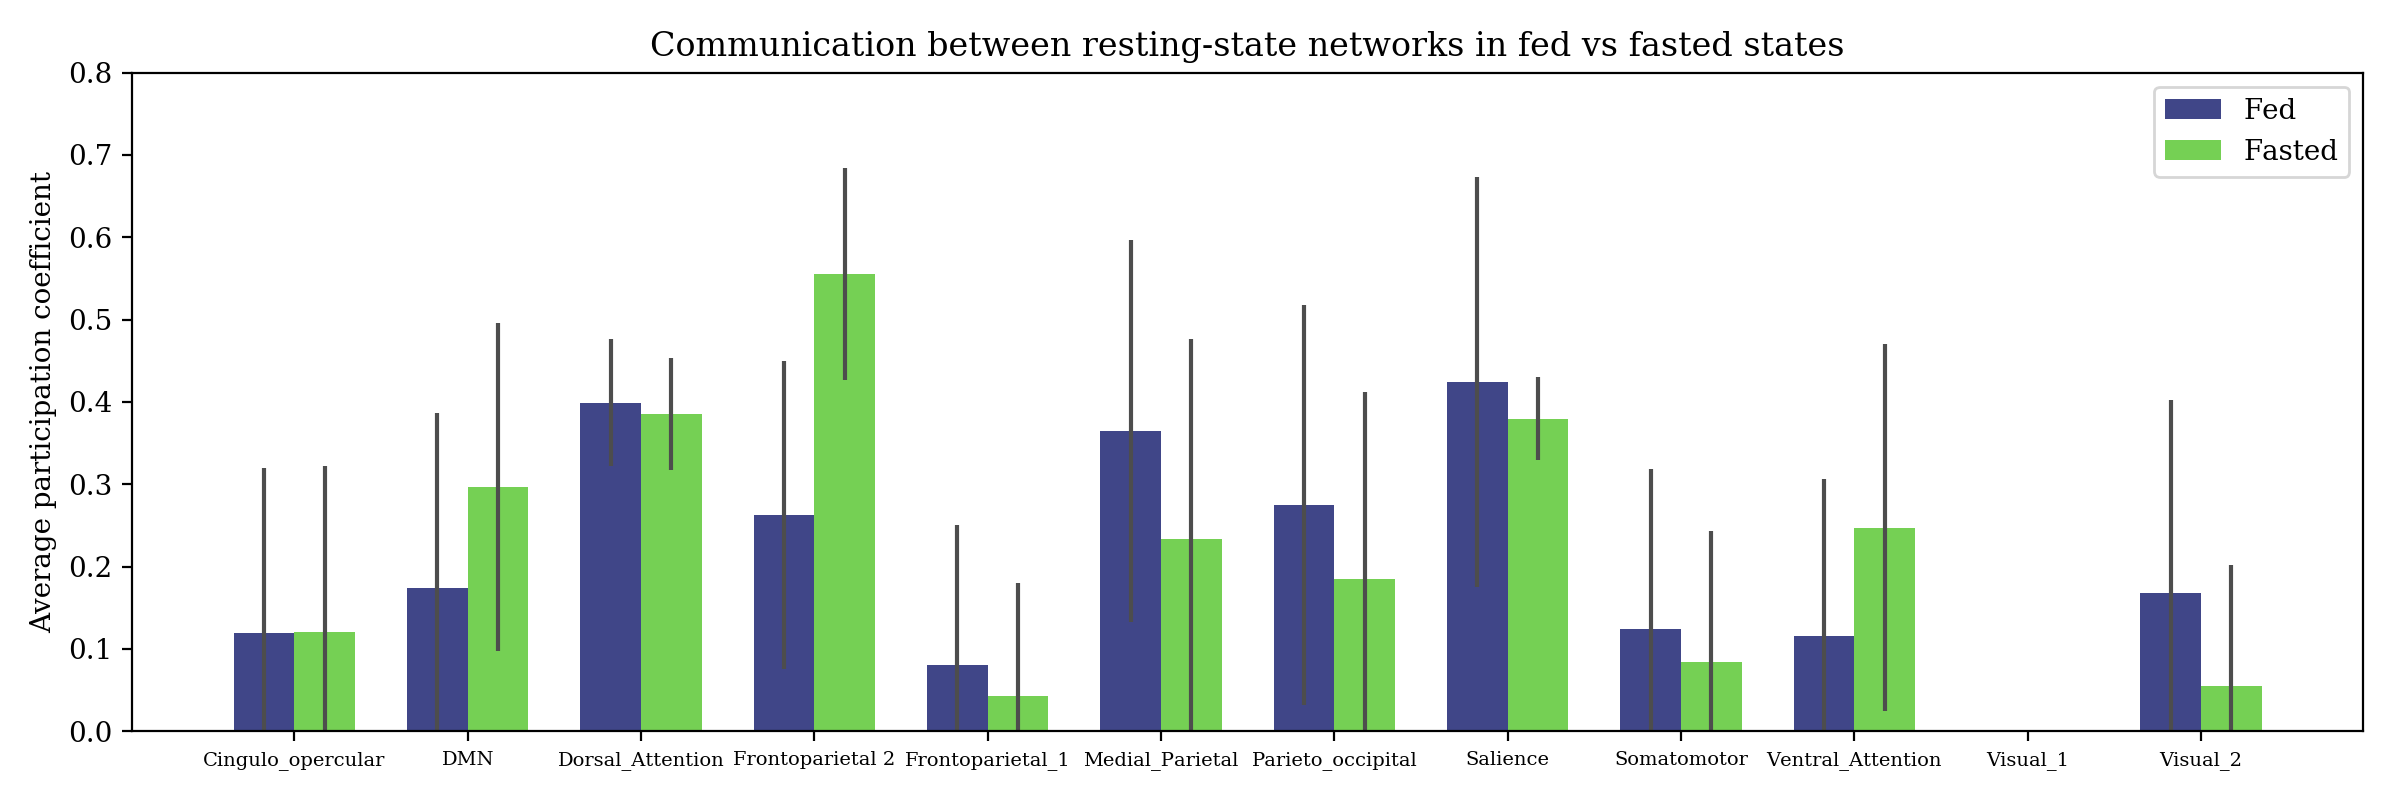

In [159]:
_,part_fed = get_mod(dGfed.G_,return_partition=True)
_,part_fast = get_mod(dGfast.G_,return_partition=True)

Afed = nx.to_numpy_array(dGfed.G_)
Afast = nx.to_numpy_array(dGfast.G_)

Cfed = [np.where(majorRSNs == part_fed[node]) for node in dGfed.G_.nodes()] # Return a number corresponding to an RSN community
Cfast = [np.where(majorRSNs == part_fast[node]) for node in dGfast.G_.nodes()]  

p_fed = calc_particip(dGfed.G_,part_fed,Afed,Cfed)
p_fast = calc_particip(dGfast.G_,part_fast,Afast,Cfast)

plot_network_measure(p_fed,p_fast,
                     'Average participation coefficient',
                     'Communication between resting-state networks in fed vs fasted states',
                     0.8
                    )

#### ROI x ROI matrix

In [83]:
def rsn_index_change(sorted_rsns):
    """
    Process sorted array of network labels, return an array of indexes where the label changes
    """
    index_array = []
    current_label = 'batman'
    for ind,label in enumerate(sorted_rsns):
        if label != current_label:
            current_label = label
            index_array.append(ind)
    # Add ending index
    index_array.append(len(sorted_rsns)-1)
    return index_array

In [11]:
from matplotlib import patches

def add_rsn_patches(ax, lenx, leny, boundaries, color_array, alpha_param = 1.0, offset = 1.0):
    """
    Plots rectangular patches vertically and horizontally for each network bounded by the indices
    provided using the colors provided
    """
    # Loop through boundaries
    for num,ind in enumerate(boundaries[:-1]):
        nextind = boundaries[num+1]
        hrect = patches.Rectangle((ind,ind), nextind-ind, nextind-ind,linewidth=1.5,edgecolor=color_array[num],facecolor='none',alpha=alpha_param)
        ax.add_patch(hrect)
        vrect = patches.Rectangle((ind,ind), nextind-ind, nextind-ind,linewidth=1.5,edgecolor=color_array[num],facecolor='none',alpha=alpha_param)
        ax.add_patch(vrect)

In [206]:
import matplotlib as mpl

def plot_network_adj(TCM, plot_title, add_cbar=True):
    
    rsnidx = np.argsort(roi2rsn_clean)
    A = TCM[rsnidx,:]
    A = A[:,rsnidx]
    rect_inds = rsn_index_change(roi2rsn_clean[rsnidx])

    plt.close('all')
    plt.rc('font', family='serif')
    plt.imshow(A,cmap='binary_r')
    plt.axis('off')
    plt.title(plot_title)
    ax = plt.gca()
    fig = plt.gcf()
    cmap = mpl.cm.get_cmap('tab20', 20)
    colors = cmap(np.linspace(0,1,20))

    add_rsn_patches(ax,A.shape[1],A.shape[0],rect_inds,colors[:len(majorRSNs)],alpha_param=1.0,offset=2)
    
    # Create colorbar to label the RSN rectangles
    if add_cbar:
        # Use rect_inds to define which ticks are what colors
        # If our colormap is size of the matrix (554), then all indices within a RSN should be same color
        bar_colors = np.zeros((A.shape[0],4))
        # Holds the midpoint value of each RSN region to use for tick labels
        midticks = []
        for num,ind in enumerate(rect_inds[:-1]):
            nextind = rect_inds[num+1]
            bclr = np.matlib.repmat(colors[num],nextind-ind,1)
            bar_colors[ind:nextind,:] = bclr
            midticks.append((nextind+ind)/2.0)
        # Flip since matrix goes top to bottom
        bar_colors = bar_colors[::-1]
        midticks = A.shape[0] - np.array(midticks)
        
        cmap_bar = matplotlib.colors.ListedColormap(bar_colors)
        norm = mpl.colors.Normalize(vmin=0,vmax=A.shape[0])
        sm = plt.cm.ScalarMappable(cmap=cmap_bar, norm=norm)
        sm.set_array([])
        
        # Left colorbar
        cbaxes = fig.add_axes([0.18, 0.11, 0.02, 0.77]) 
        cbar = plt.colorbar(sm, ticks=midticks, cax = cbaxes)
        cbaxes.yaxis.set_ticks_position('left')
        rsns_pretty = np.sort(['Cingulo-opercular','Fronto-parietal 1','Somatomotor','Visual 2','DMN',
             'Dorsal Attention', 'Ventral Attention', 'Salience', 'Visual 1', 'Medial Parietal',
             'Parieto Occipital', 'Fronto-parietal 2'])
        cbar.ax.set_yticklabels(rsns_pretty)
        cbar.ax.tick_params(labelsize=7) 
    
    plt.show()

<IPython.core.display.Javascript object>


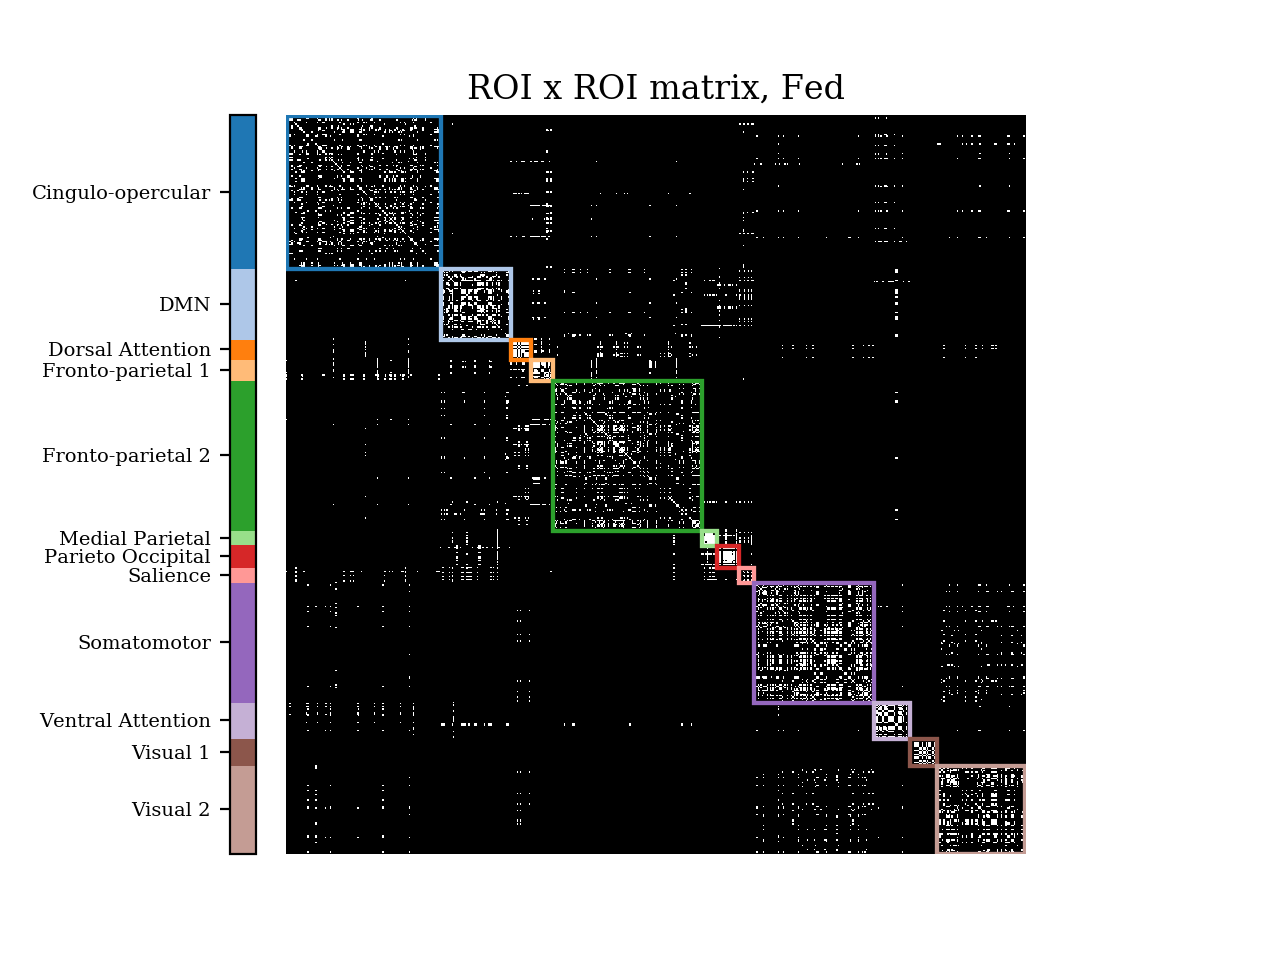

In [128]:
plot_network_adj(dGfed.tcm_,'ROI x ROI matrix, Fed',add_cbar=True)

<IPython.core.display.Javascript object>


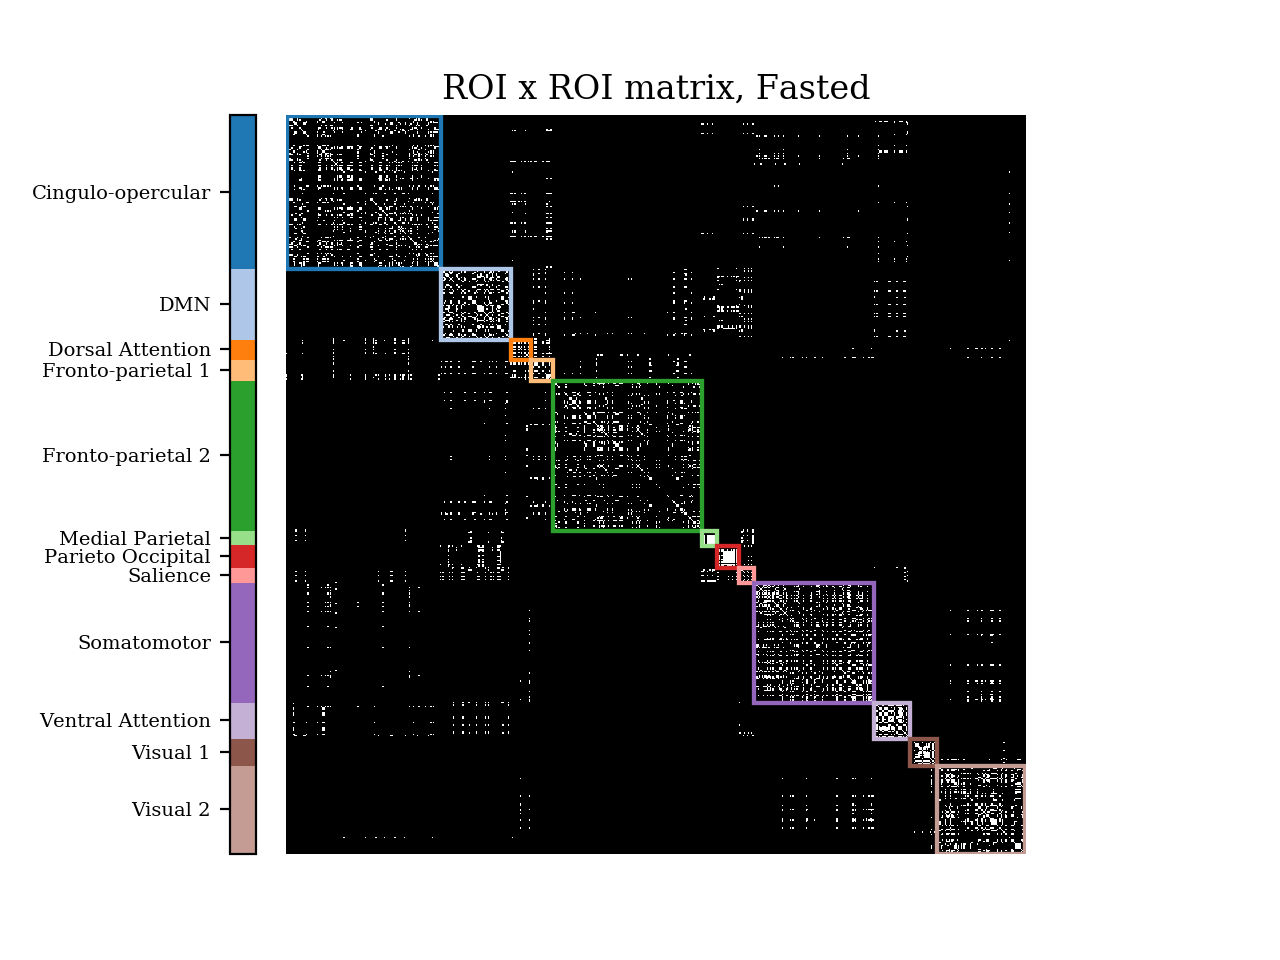

In [129]:
plot_network_adj(dGfast.tcm_,'ROI x ROI matrix, Fasted',add_cbar=True)

In [28]:
plot_network_adj(dGfed.tcm_ - dGfast.tcm_)

NameError: name 'dGfed' is not defined

### Run all network measure calculations on every session individually

Everything below this cell is important, and they use all the functions above.

In [152]:
# Loop through all sessions and get a FC
sessions = load_scrubbed(n_sessions=-1, merge=False,
                         apply_tmask=True,apply_rmask=True,
                         rmask_kwds=dict(n=12,minor=False),zscore=False)

INFO:load_data:load_scrubbed(**{'n_sessions': -1, 'merge': False, 'apply_tmask': True, 'apply_rmask': True, 'rmask_kwds': {'n': 12, 'minor': False}, 'zscore': False})
INFO:load_data:Loading data...
INFO:root:  [+] session: 0, file: sub014.txt
INFO:root:      keeping: 505 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 1, file: sub015.txt
INFO:root:      keeping: 508 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 2, file: sub016.txt
INFO:root:      keeping: 508 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 3, file: sub017.txt
INFO:root:      keeping: 504 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 4, file: sub018.txt
INFO:root:      keeping: 508 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 5, file: sub019.txt
INFO:root:      keeping: 513 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 6, file: sub020

INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 63, file: sub082.txt
INFO:root:      keeping: 502 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 64, file: sub083.txt
INFO:root:      keeping: 482 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 65, file: sub084.txt
INFO:root:      keeping: 515 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 66, file: sub085.txt
INFO:root:      keeping: 518 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 67, file: sub086.txt
INFO:root:      keeping: 515 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 68, file: sub087.txt
INFO:root:      keeping: 516 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 69, file: sub088.txt
INFO:root:      keeping: 516 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 70, file: sub089.txt
INFO:root:      kee

In [196]:
# List of dictionaries for each session each keyed by RSN, and values are lists with a value for every node
btw_fed = []
btw_fast = []
btw_null = []
wmod_fed = []
wmod_fast = []
wmod_null = []
Qfed = []
Qfast = []
Qnull = []
p_fed = []
p_fast = []
p_null = []

# List of matrices
Afed = []
Afast = []
Anull = []

bestres = 20
bestgain = 8.
overlap = (bestgain - 1) / bestgain

for sess_num,session in enumerate(sessions):
    day = int(session.meta['day_of_week'][0])
    if day != 4 and day != 2: continue
    print('Processing session %d...' % (sess_num+1))
    # Zscore data
    Xz = scipy.stats.zscore(session.X,axis=0)
    # Run Mapper/DyNeuSR
    results = run_mapper(Xz.T,df_roi_rsn,cover=km.Cover(bestres,overlap))
    G = results['dG'].G_
    Q,part = get_mod(G,return_partition=True)
    actualA = nx.to_numpy_array(G)
    C = [np.where(majorRSNs == part[node]) for node in G.nodes()] # Return a number corresponding to an RSN community 

    if day == 2: # Fasted
        btw_fast.append(betweenness(G,part))
        wmod_fast.append(within_module_degree(G,part,normalize=True))
        Qfast.append(Q)
        Afast.append(results['dG'].tcm_)
        p_fast.append(calc_particip(G,part,actualA,C))
        results['dG'].visualize(path_html='results/fasted%d_spatial.html' % (sess_num+1), show=False, reset=True, static=False, PORT=8800)
    elif day == 4: # Fed
        btw_fed.append(betweenness(G,part))
        wmod_fed.append(within_module_degree(G,part,normalize=True))
        Qfed.append(Q)
        Afed.append(results['dG'].tcm_)
        p_fed.append(calc_particip(G,part,actualA,C))
        results['dG'].visualize(path_html='results/fed%d_spatial.html' % (sess_num+1), show=False, reset=True, static=False, PORT=8800)
    
    # Run SBM
    sbm = nullSBM()
    sbm.set_params(results['dG'].G_)
    sbm.run(num_itera=1)
    btw_null.append(betweenness(sbm.G_,sbm.partition))
    wmod_null.append(within_module_degree(sbm.G_,sbm.partition,normalize=True))
    Qnull.append(community.modularity(sbm.partition,sbm.G_))
    Anull.append(sbm.A)
    p_null.append(calc_particip(sbm.G_,sbm.partition,sbm.A,list(sbm.partition.values())))

Processing session 1...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fed1_spatial.html
Processing session 3...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fasted3_spatial.html
Processing session 4...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fed4_spatial.html
Processing session 6...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fasted6_spatial.html
Processing session 7...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fed7_spatial.html
Processing session 9...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fasted9_spatial.html
Processing session 10...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fed10_spatial.html
Processing session 12...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fasted12_spatial.html
Processing session 13...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fasted13_spatial.html
Processing session 15...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fasted15_spatial.html
Processing session 16...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fed16_spatial.html
Processing session 18...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fed18_spatial.html
Processing session 19...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fed19_spatial.html
Processing session 21...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fasted21_spatial.html
Processing session 22...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fed22_spatial.html
Processing session 23...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fasted23_spatial.html
Processing session 24...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fed24_spatial.html
Processing session 26...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fasted26_spatial.html
Processing session 27...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fed27_spatial.html
Processing session 29...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fasted29_spatial.html
Processing session 31...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fasted31_spatial.html
Processing session 32...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fed32_spatial.html
Processing session 34...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fasted34_spatial.html
Processing session 35...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fed35_spatial.html
Processing session 37...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fasted37_spatial.html
Processing session 38...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fasted38_spatial.html
Processing session 40...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fasted40_spatial.html
Processing session 41...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fed41_spatial.html
Processing session 42...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fasted42_spatial.html
Processing session 43...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fed43_spatial.html
Processing session 44...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fasted44_spatial.html
Processing session 45...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fed45_spatial.html
Processing session 46...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fasted46_spatial.html
Processing session 47...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fasted47_spatial.html
Processing session 48...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fed48_spatial.html
Processing session 49...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fasted49_spatial.html
Processing session 50...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fasted50_spatial.html
Processing session 51...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fasted51_spatial.html
Processing session 52...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fasted52_spatial.html
Processing session 53...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fed53_spatial.html
Processing session 54...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fasted54_spatial.html
Processing session 55...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fed55_spatial.html
Processing session 56...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fasted56_spatial.html
Processing session 57...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fed57_spatial.html
Processing session 58...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fasted58_spatial.html
Processing session 59...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fed59_spatial.html
Processing session 60...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fasted60_spatial.html
Processing session 61...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fasted61_spatial.html
Processing session 62...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fed62_spatial.html
Processing session 63...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fasted63_spatial.html
Processing session 64...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fed64_spatial.html
Processing session 65...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fasted65_spatial.html
Processing session 66...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fed66_spatial.html
Processing session 67...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fasted67_spatial.html
Processing session 68...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fasted68_spatial.html
Processing session 69...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fed69_spatial.html
Processing session 70...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fasted70_spatial.html
Processing session 71...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fed71_spatial.html
Processing session 72...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fasted72_spatial.html
Processing session 73...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fed73_spatial.html
Processing session 74...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fasted74_spatial.html
Processing session 75...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fasted75_spatial.html
Processing session 76...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fed76_spatial.html
Processing session 77...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fasted77_spatial.html
Processing session 78...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fed78_spatial.html
Processing session 79...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fasted79_spatial.html
Processing session 80...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fed80_spatial.html
Processing session 81...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fasted81_spatial.html
Processing session 82...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


[Force Graph] http://localhost:8800/results/fed82_spatial.html
Processing session 83...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fed83_spatial.html
Processing session 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fasted84_spatial.html


/Users/rafi/Documents/Stanford/Saggar_Lab/bctpy/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


#### ROI x ROI matrix

<IPython.core.display.Javascript object>


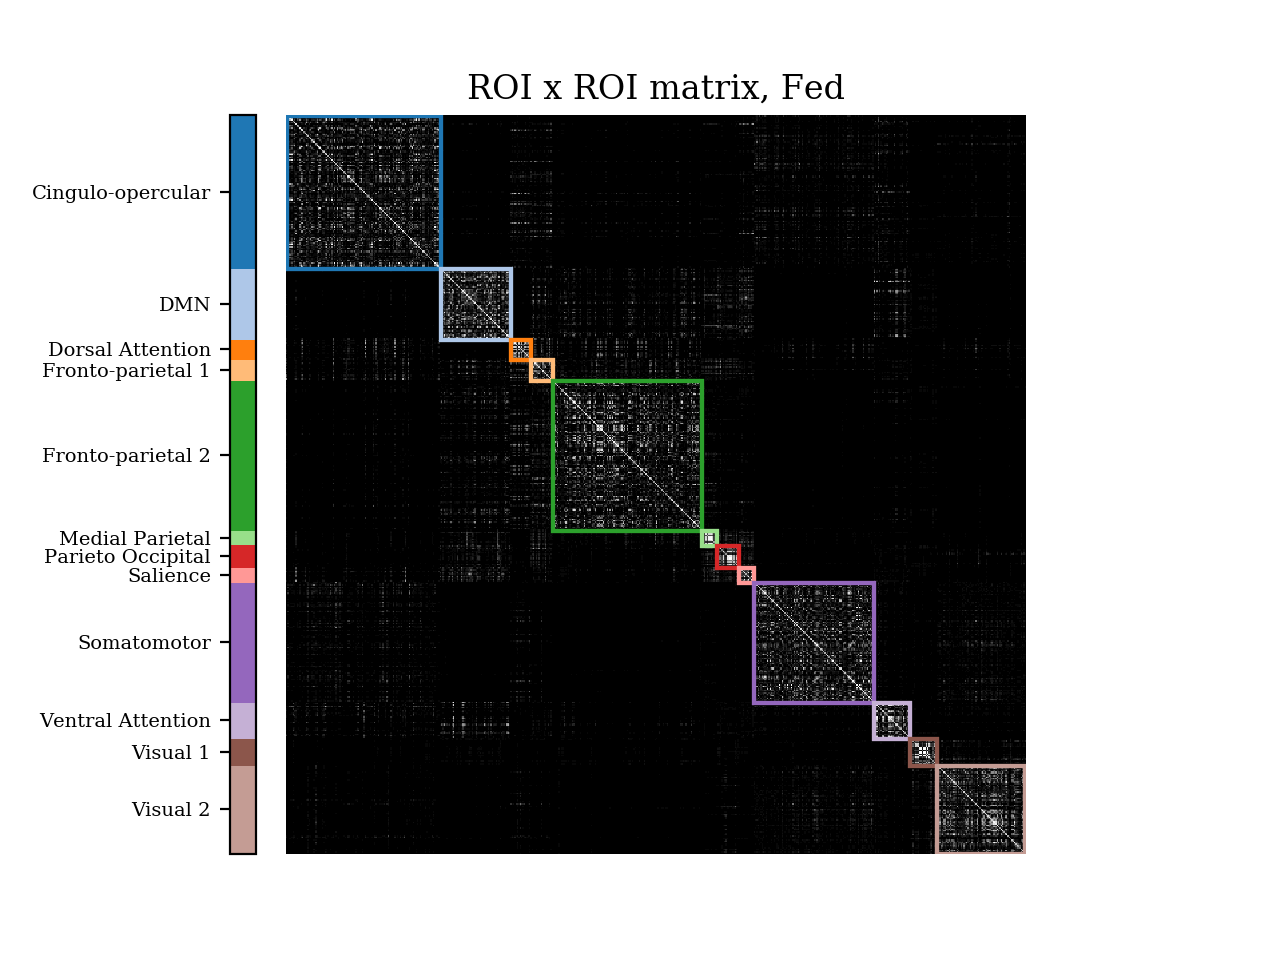

In [207]:
Afed_mean = np.mean(Afed,axis=0)
plot_network_adj(Afed_mean,'ROI x ROI matrix, Fed')
plt.savefig('figures/fed_ram.jpg',dpi=300)

<IPython.core.display.Javascript object>


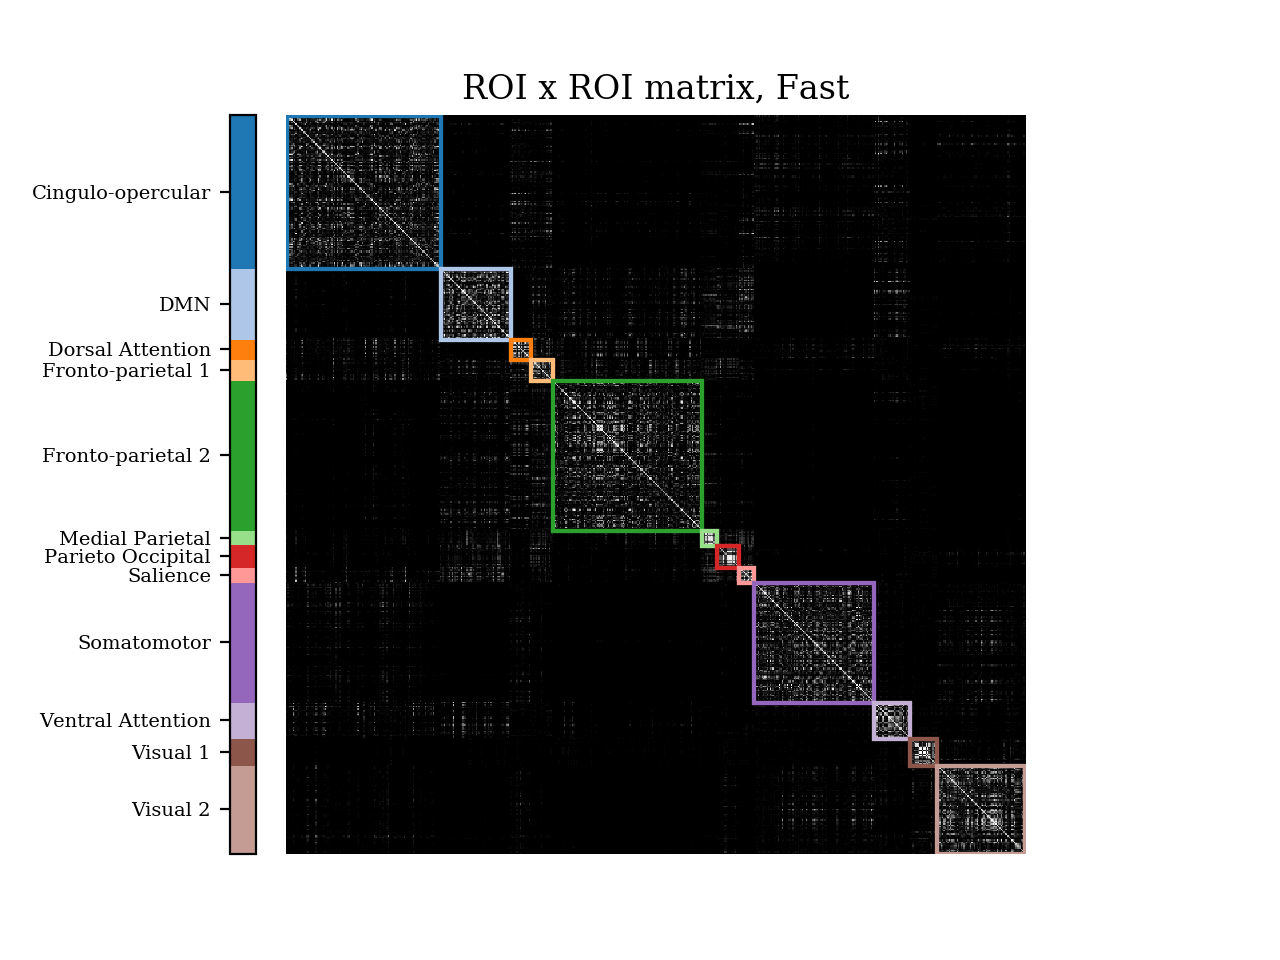

In [208]:
Afast_mean = np.mean(Afast,axis=0)
plot_network_adj(Afast_mean, 'ROI x ROI matrix, Fast')
plt.savefig('figures/fast_ram.jpg',dpi=300)

Does this match the FC matrix?

<IPython.core.display.Javascript object>


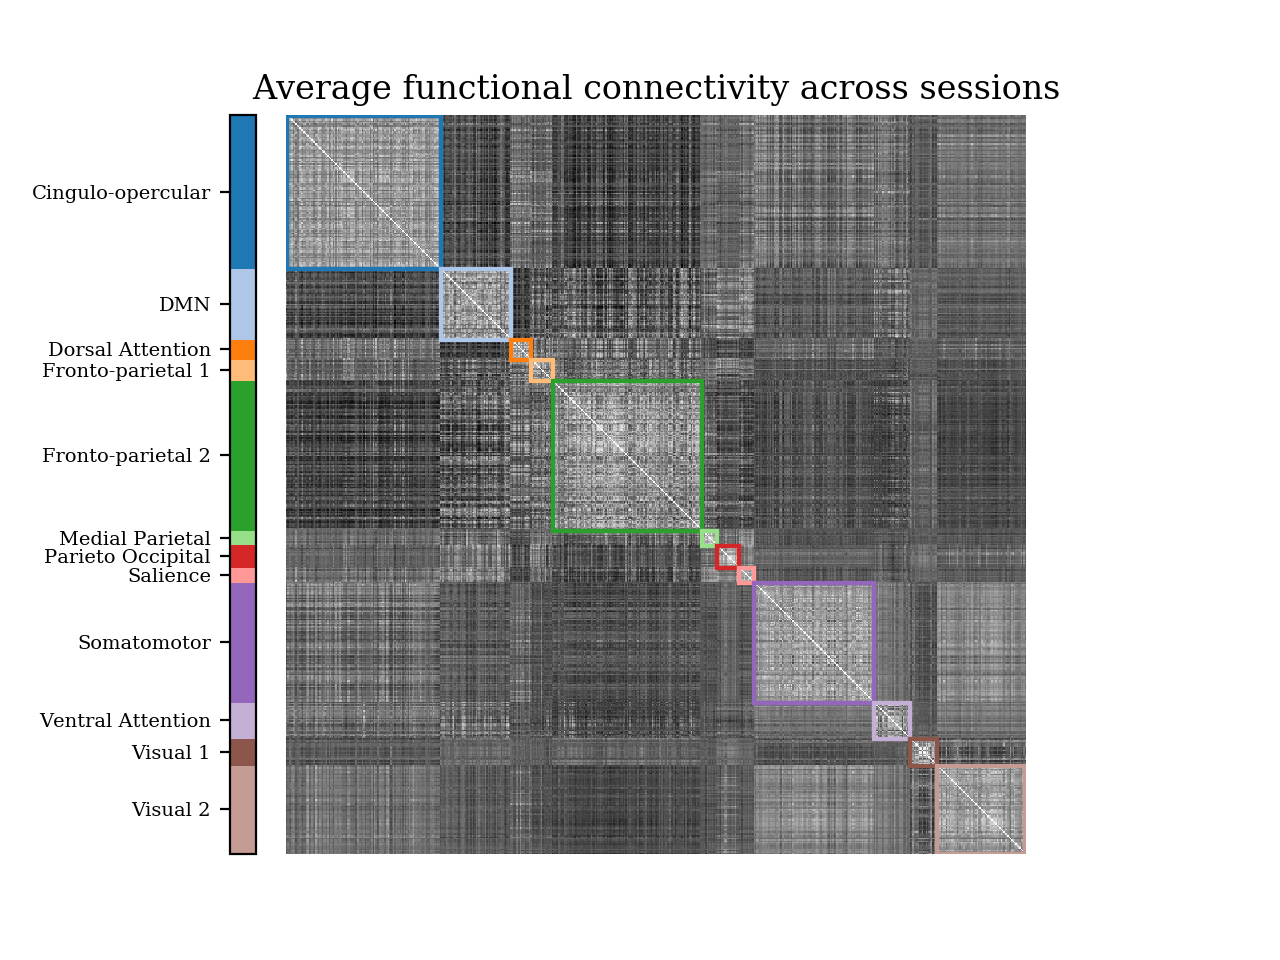

In [209]:
fc = [np.corrcoef(session.X.T) for session in sessions]
fcmean = np.mean(fc,axis=0)
plot_network_adj(fcmean,'Average functional connectivity across sessions')
plt.savefig('figures/fc_ram.jpg',dpi=300)

#### Modularity

<IPython.core.display.Javascript object>


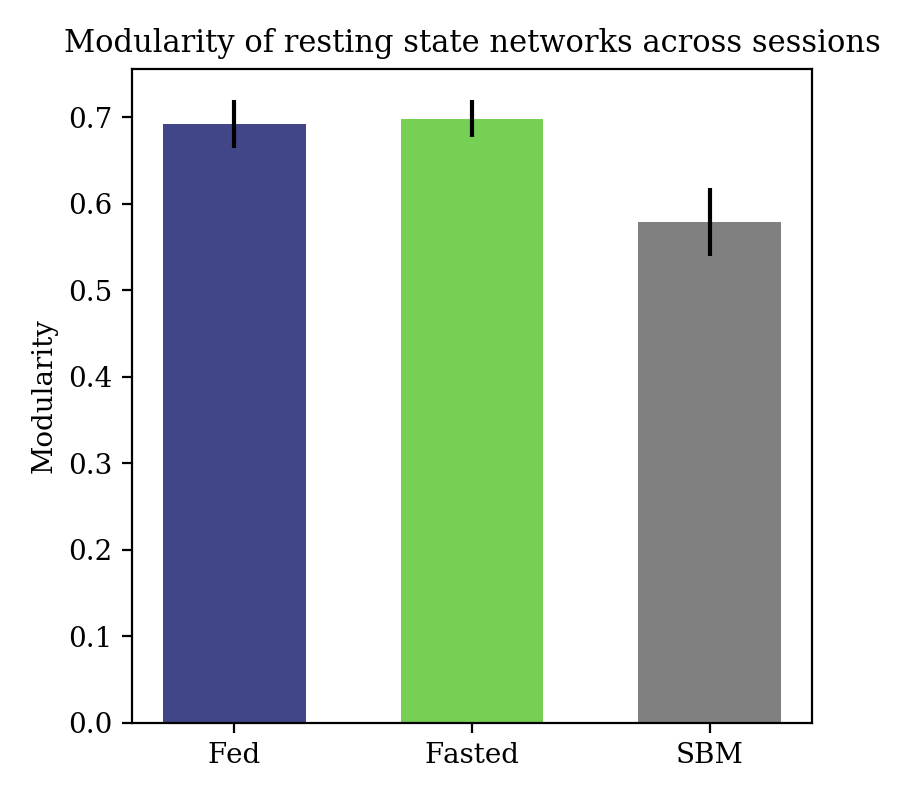

In [210]:
Qfed_mean = np.mean(Qfed)
Qfed_std = np.std(Qfed)
Qfast_mean = np.mean(Qfast)
Qfast_std = np.std(Qfast)
Qnull_mean = np.mean(Qnull)
Qnull_std = np.std(Qnull)

barlabels = ['Fed','Fasted','SBM']
barh = [Qfed_mean,Qfast_mean,Qnull_mean]
barerr = [Qfed_std,Qfast_std,Qnull_std]
bar_width = 0.15
cmap = cm.get_cmap('viridis', 20)
colors = cmap(np.linspace(0,1,10))

plt.close('all')
plt.figure(figsize=(4.5,4))
plt.bar([0.25,0.50,0.75],barh,bar_width,yerr=barerr,color=[colors[2],colors[7],'gray'])
plt.xticks([0.25,0.50,0.75], barlabels, fontsize=10)
plt.ylabel('Modularity')
plt.title('Modularity of resting state networks across sessions', fontsize=11)
fig = plt.gcf()
fig.tight_layout()
plt.savefig('figures/mod.jpg',dpi=300)
plt.show()

#### Within module degree

<IPython.core.display.Javascript object>


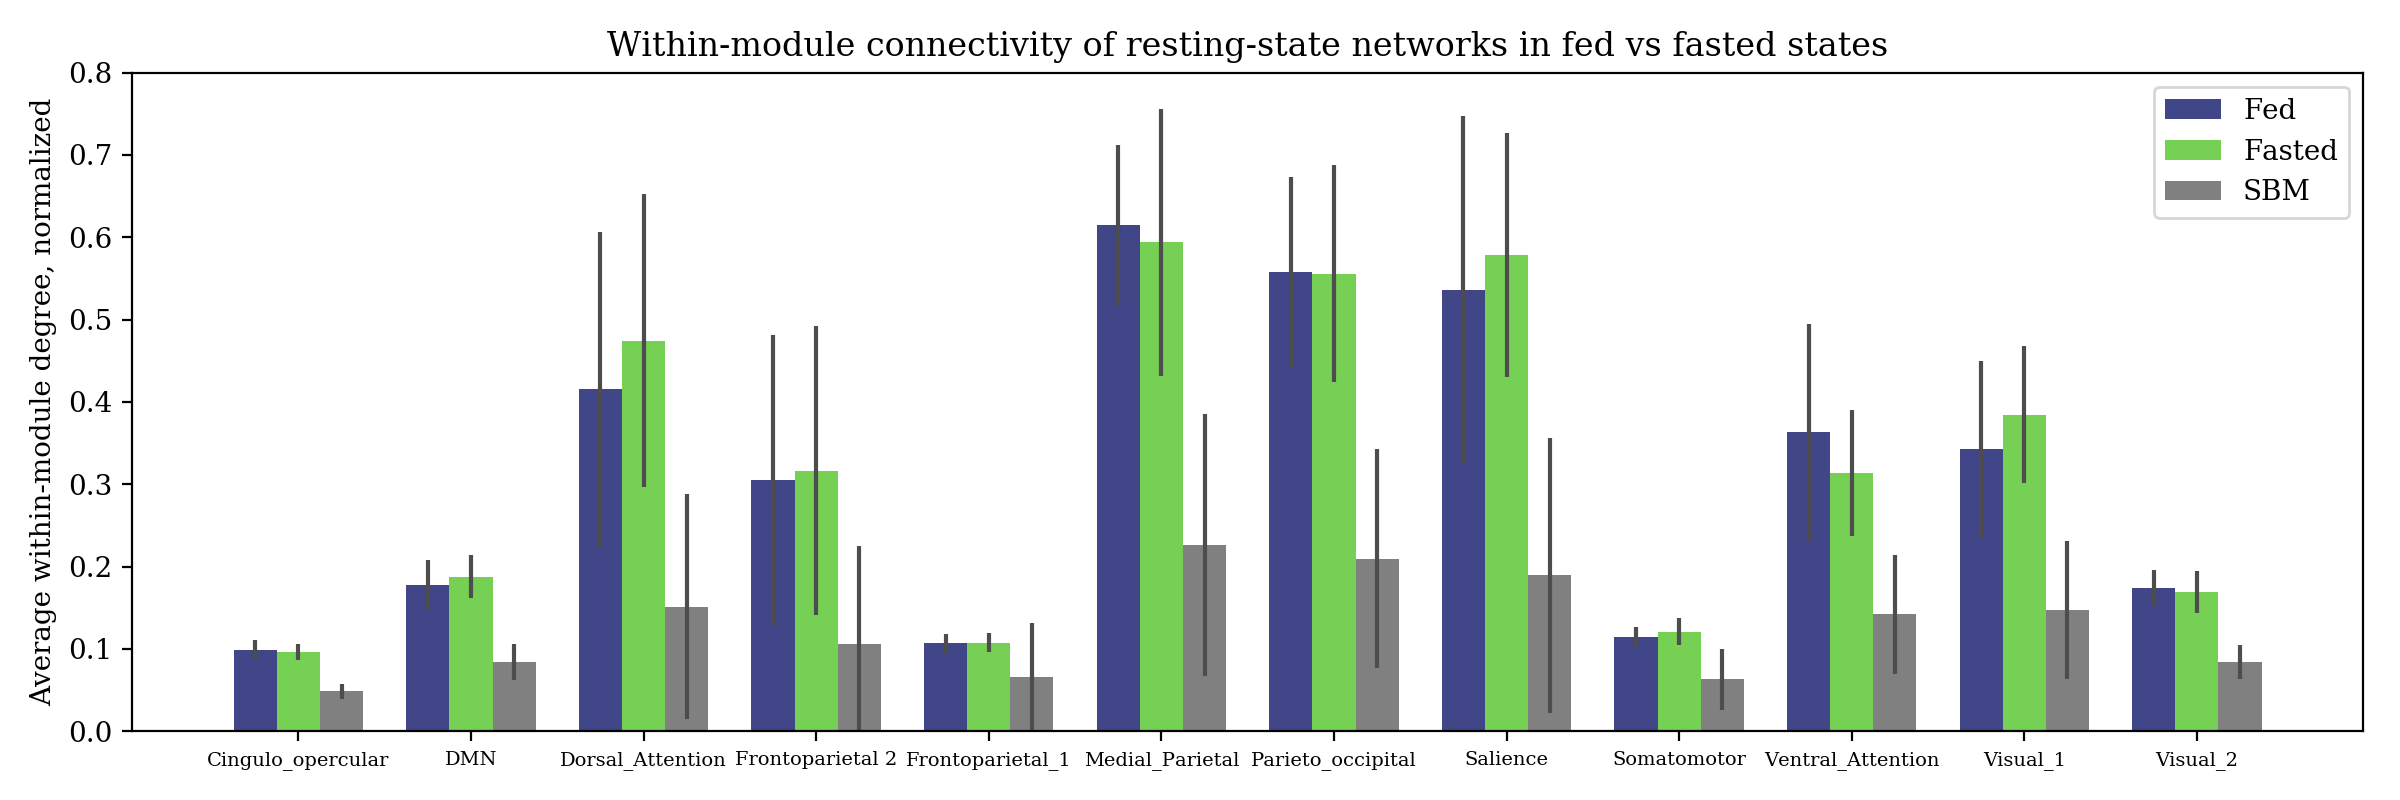

In [211]:
rsnstats_fed = collections.defaultdict(list)
for session in wmod_fed:
    for rsn in session:
        rsnstats_fed[rsn].append(np.mean(session[rsn]))

rsnstats_fast = collections.defaultdict(list)
for session in wmod_fast:
    for rsn in session:
        rsnstats_fast[rsn].append(np.mean(session[rsn]))
        
rsnstats_null = collections.defaultdict(list)
for session in wmod_null:
    for rsn in session:
        rsnstats_null[rsn].append(np.mean(session[rsn]))
        
plot_network_measure(rsnstats_fed,rsnstats_fast,
                     'Average within-module degree, normalized',
                     'Within-module connectivity of resting-state networks in fed vs fasted states',
                     0.8,
                     null_measure=rsnstats_null
                    )
plt.savefig('figures/wmod.jpg',dpi=300)

#### Betweenness centrality

<IPython.core.display.Javascript object>


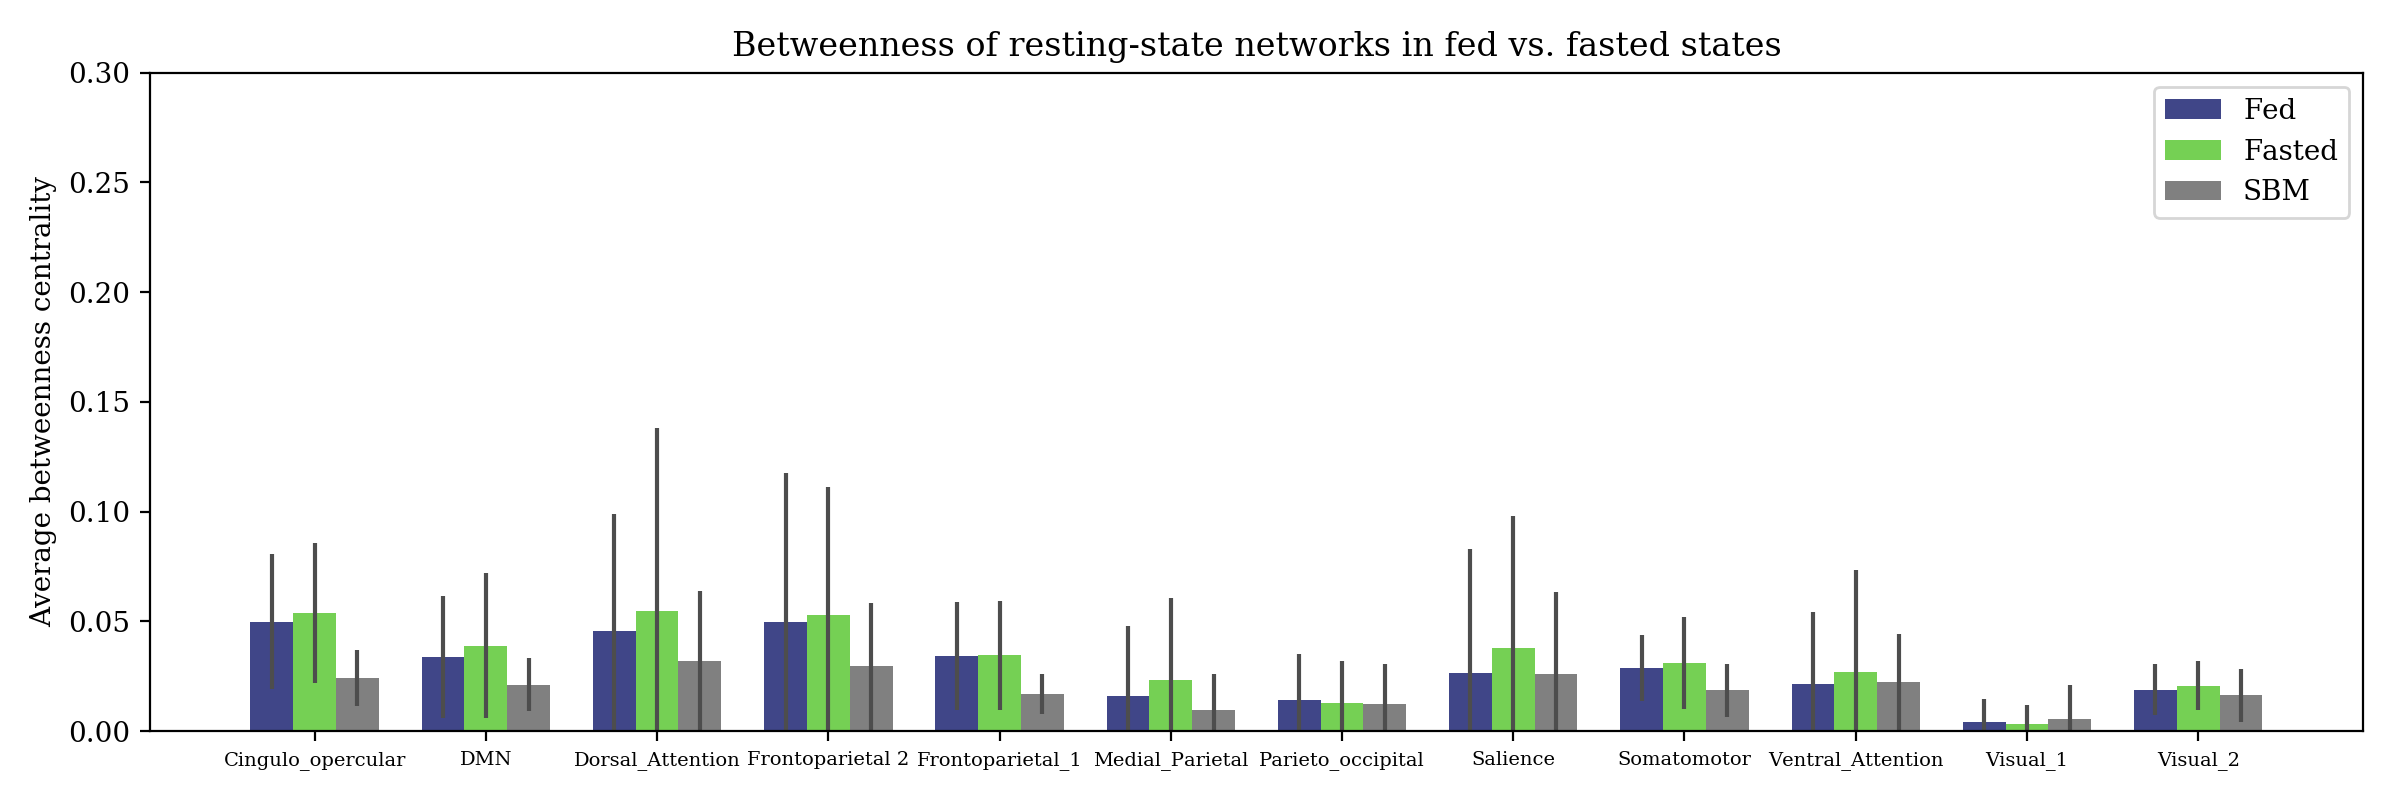

In [212]:
rsnstats_fed = collections.defaultdict(list)
for session in btw_fed:
    for rsn in session:
        rsnstats_fed[rsn].append(np.mean(session[rsn]))
        
rsnstats_fast = collections.defaultdict(list)
for session in btw_fast:
    for rsn in session:
        rsnstats_fast[rsn].append(np.mean(session[rsn]))
        
rsnstats_null = collections.defaultdict(list)
for session in btw_null:
    for rsn in session:
        rsnstats_null[rsn].append(np.mean(session[rsn]))
        
plot_network_measure(rsnstats_fed,rsnstats_fast,
                     'Average betweenness centrality',
                     'Betweenness of resting-state networks in fed vs. fasted states',
                     0.3,
                     null_measure=rsnstats_null
                    )
plt.savefig('figures/btw.jpg',dpi=300)

#### Participation Coefficient

<IPython.core.display.Javascript object>


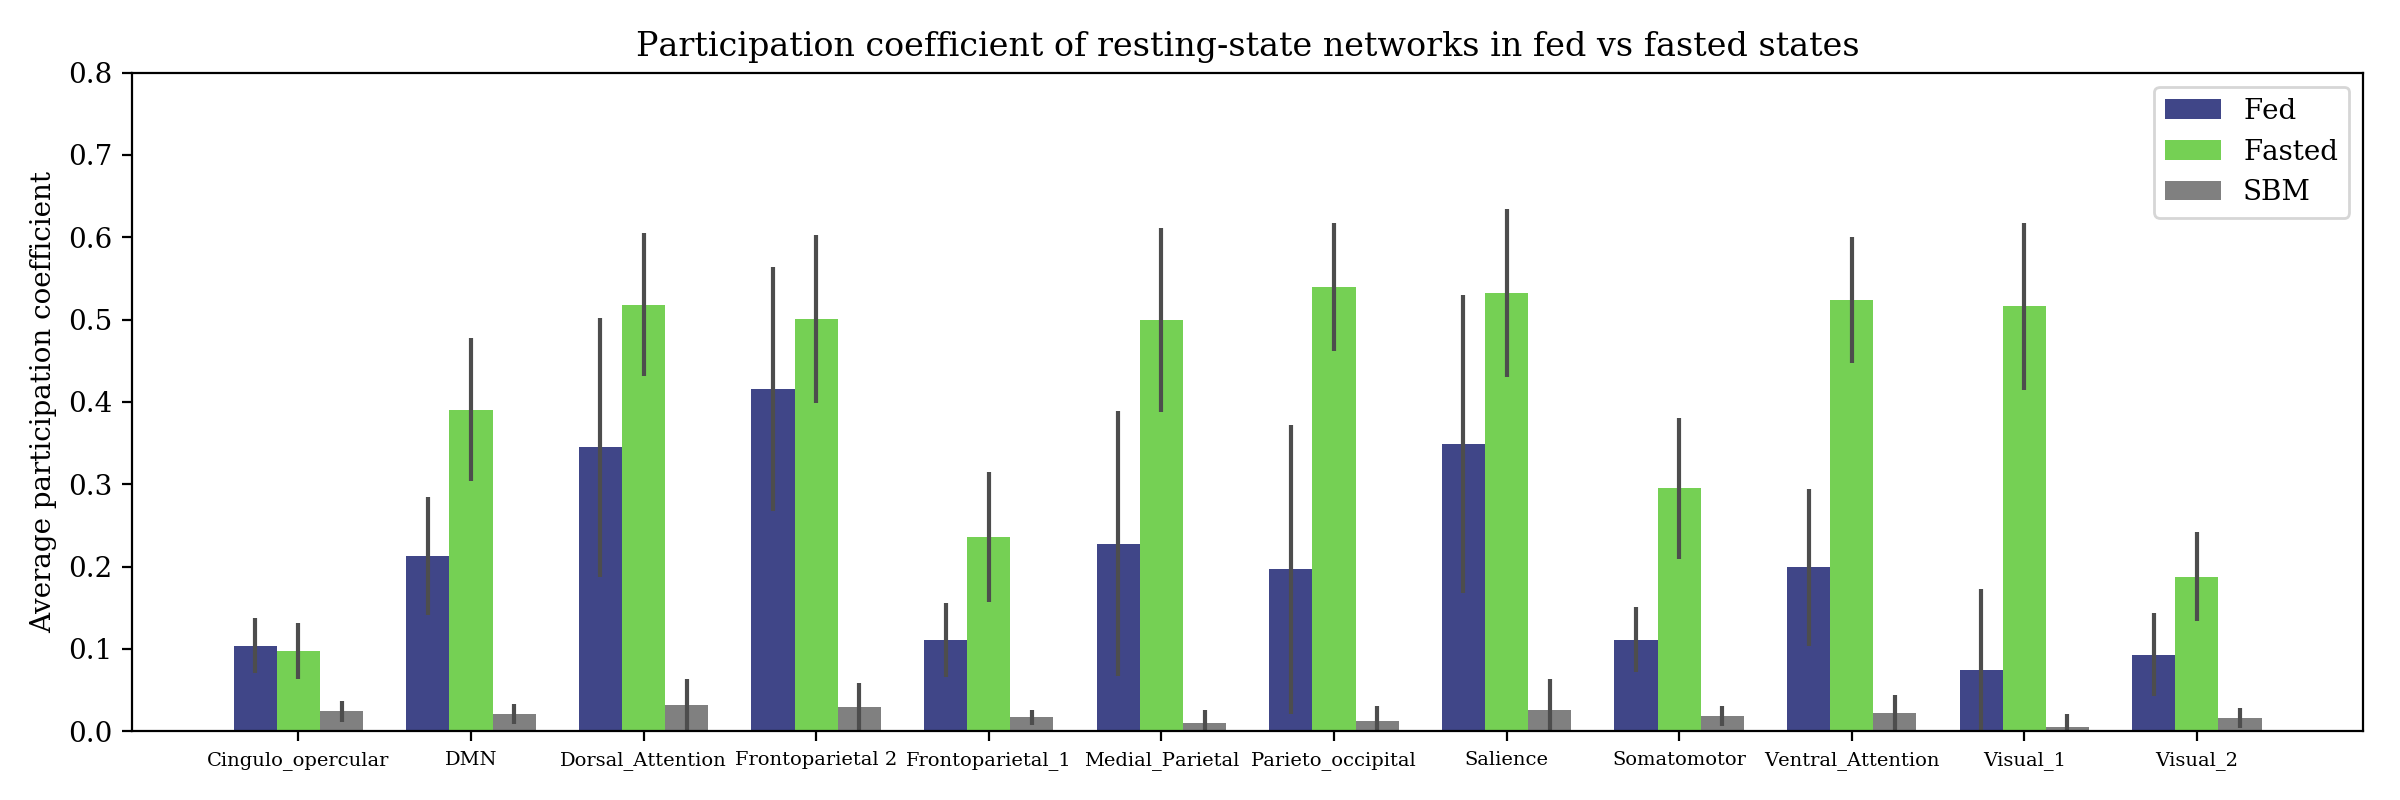

In [213]:
rsnstats_fed = collections.defaultdict(list)
for session in p_fed:
    for rsn in session:
        rsnstats_fed[rsn].append(np.mean(session[rsn]))
        
rsnstats_fast = collections.defaultdict(list)
for session in p_fast:
    for rsn in session:
        rsnstats_fast[rsn].append(np.mean(session[rsn]))
        
rsnstats_fast = collections.defaultdict(list)
for session in p_null:
    for rsn in session:
        rsnstats_fast[rsn].append(np.mean(session[rsn]))
        
plot_network_measure(rsnstats_fed,rsnstats_fast,
                     'Average participation coefficient',
                     'Participation coefficient of resting-state networks in fed vs fasted states',
                     0.8,
                     null_measure=rsnstats_null
                    )
plt.savefig('figures/particip.jpg',dpi=300)